# M3 Reconstruction
### Using the 3 highest P_{T} jets Lorentz Vector to construct and invariant mass. Known as M3 Reconstruction
By Zach Shelton
01/25/2021

In [8]:
#NanoAOD HackSchema
#Solution from Danny Noonan


In [28]:
from __future__ import print_function, division
import uproot
import numpy as np
#Make sure to install both old awkward0 and new awkward1(referred to now as awkward)
import awkward as ak
import awkward0 as ak0
from coffea.nanoevents import NanoAODSchema,NanoEventsFactory
from uproot3_methods import TLorentzVectorArray
import uproot3_methods
import numpy as np
import awkward
class HackSchema(NanoAODSchema):
    def __init__(self, base_form):
        base_form["contents"].pop("Muon_fsrPhotonIdx", None)
        base_form["contents"].pop("Electron_photonIdx", None)
        super().__init__(base_form)
def m3_recon(tree):
    comb= ak.combinations(tree,n=3,axis=1,fields=['j1','j2','j3'])
    trijets= comb.j1+comb.j2+comb.j3
    recon =ak.max(trijets,axis=1)
    reconfinal=np.sqrt(recon.t*recon.t-recon.x*recon.x-recon.y*recon.y-recon.z*recon.z)
    #MISUSE/CONFUSION:
    #for some reason None values are being placed in array
    #So I reconstructed the mass "manually"
    list1= ak.to_numpy(reconfinal)
    return list1
files ="TTbarPowheg_Semilept_Skim_NanoAOD_1of21.root"

## Note: It seems the Jet columns are sorted from greatest p_t to smallest p_t
Feel free to test, but it seems to be my observation, choosing the 1st, 2nd or 3rd jet via index should remove the issue of it being a coffea sorting artifact or procedure

In [40]:
#Now lets redo with the cuts detailed by CMS Draft Analysis
#https://drive.google.com/file/d/1XEOLyZ-Q1HdEQY379RpyyQkOF1Q8KlsL/view
events =NanoEventsFactory.from_root(files,schemaclass=HackSchema).events()


In [126]:
#Condensing All Cuts to a single Cell
tight_jets=events.Jet
print(tight_jets)
jetSelection = ak.num(tight_jets[((tight_jets.pt>30)&(tight_jets.eta<2.4)&(tight_jets.eta>-2.4))],axis=1)>=3

[[Jet, Jet, Jet, Jet, Jet], [Jet, Jet, ... Jet, Jet, Jet, Jet, Jet, Jet, Jet, Jet]]


In [128]:
print(len(jetSelection))

1734354


In [72]:
recon_precuts = m3_recon(tight_jets)

/udrive/student/zshelton2015/TopAnalysisExample/ttgenv/lib/python3.6/site-packages/awkward/_connect/_numpy.py:151: RuntimeWarning: invalid value encountered in sqrt
  *[nplike.asarray(x) for x in inputs], **kwargs


In [130]:
#Condensing_all Lepton_cuts
tight_muons = events.Muon
muonsel=ak.num(tight_muons[((tight_muons.pt>30)&(abs(tight_muons.eta)<2.4))],axis=1)==1
tight_electrons= events.Electron
electronsel=ak.num(tight_electrons[((tight_electrons.pt>35)&(abs(tight_electrons.eta)<2.4))],axis=1)==1

In [131]:
jetlepselmask = (jetSelection&leptonsel)
print((jetlepselmask))
print(events[jetlepselmask])
final=events[jetlepselmask]
postcuts_m3=m3_recon(events[jetlepselmask].Jet)

[True, False, False, False, False, False, ... True, True, False, False, False, False]
[<event 1:50992:8498517>, <event 1:50992:8498524>, ... <event 1:641843:106973889>]


<AxesSubplot:xlabel='p_{t}', ylabel='p_t Comparison'>

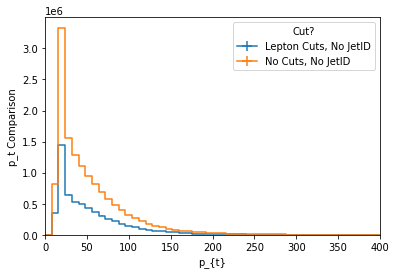

In [132]:
import coffea.hist as hist
cat=hist.Cat("cut","Cut?")
bins=hist.Bin("p_t","p_{t}",50,0,400)
histogram= hist.Hist("p_t Comparison",cat,bins)
histogram.fill(cut="No Cuts, No JetID",p_t=ak.flatten(events.Jet.pt))
#histogram.fill(cut="Simple Cuts, No JetID",p_t=ak.flatten(simplecuts.Jet.pt))
histogram.fill(cut="Lepton Cuts, No JetID",p_t=ak.flatten(events[jetlepselmask].Jet.pt))
hist.plot1d(histogram,overlay='cut')

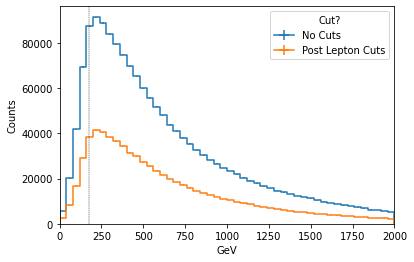

In [134]:
#M3 Reconstruction
import coffea.hist as hist
import matplotlib.pyplot as plt
cat=hist.Cat("cut","Cut?")
bins=hist.Bin("M3","GeV",50,0,2000)
histogram= hist.Hist("Counts",cat,bins)
#histogram.fill(cut="Lepton Cuts",M3=postcuts_m3)
histogram.fill(cut="No Cuts",M3=recon_precuts)
#histogram.fill(cut="Simple p_t and eta cuts",M3=simpcutsrecon)
histogram.fill(cut="Post Lepton Cuts",M3=postcuts_m3)
fig=hist.plot1d(histogram,overlay='cut',density=False)
fig.axvline(173, color='k', linestyle='dashed', linewidth=.4)
#They seem to be identical? Should they be different?

Conclusions?
2/15/21
I find that the density of the M3 reconstruction still matches the original uncut values. 
- Is there missing parameter I am not factoring in?
- Now, it seems I am applying the cuts correctly
- I want to overlay a plot with "correct jets" from the generator
- Neural Network data Prepararation



## What's next?? Worth Including? Are these covered in the CMS Analysis notes?
- Jet TightID
- More 
- Particle Values
- Delta R

Wrap into Coffea Executor
Seperate values, weights and triggers
read these into tensors for Keras
Best ML Algorithm?
- Deep Neural Net
- Iterative Boosted Tree
    - They are fast
    - External ML algorithm modifies BDT parameters
- Combine old processes together
Should I use Keras or PyTorch?


## Sources/Further Reading:

CMS Draft Analysis Note(FIT, AAS, Wayne State, NISTR): https://drive.google.com/file/d/1XEOLyZ-Q1HdEQY379RpyyQkOF1Q8KlsL/view

Invariant Mass Wikipedia Article: https://en.wikipedia.org/wiki/Invariant_mass

Measurement of the semileptonic tt + γ production cross-section in pp collisions at √s = 8 Tev: https://arxiv.org/pdf/1706.08128.pdf

Coffea Documentation: https://coffeateam.github.io/coffea/

Awkward Array Documentation: https://awkward-array.readthedocs.io/en/latest/

# Will be availible on Github: under username zshelton2015